<a href="https://colab.research.google.com/github/ashishthomaschempolil/Santander-Customer-Satisfaction/blob/master/modelling_logTransformed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
import sklearn
from sklearn import metrics,ensemble,model_selection,linear_model,tree,calibration
import xgboost as xgb
import lightgbm as lgb
import scipy
import random
from tqdm import tqdm
import os
np.random.seed(13154)

In [2]:
file = [k for k in os.listdir('/content/drive/My Drive/Santander_Customer_Satisfaction') if (('train' in k)|('test' in k))&('X' not in k)] #getting all the necessary files for modelling
file

['train_Normal.pkl',
 'test_Normal.pkl',
 'train_Normal with Response encoding.pkl',
 'test_Normal with Response encoding.pkl',
 'train_Normal with One Hot Encoding.pkl',
 'test_Normal with One Hot Encoding.pkl',
 'train_Log Transformed.pkl',
 'test_Log Transformed.pkl',
 'train_Log Transformed with Response encoding.pkl',
 'test_Log Transformed with Response encoding.pkl',
 'train_Log Transformed with One Hot Encoding.pkl',
 'test_Log Transformed with One Hot Encoding.pkl']

In [3]:
file_path = '/content/drive/My Drive/Santander_Customer_Satisfaction/'
train_file = file_path+file[6] #log transformed
test_file = file_path+file[7]
dataset= "Log Transformed"
train = pd.read_pickle(train_file)
test = pd.read_pickle(test_file)
X_train = train.drop(['ID','TARGET'],axis=1)
y_train = train['TARGET'].values
X_test = test.drop('ID',axis=1)
del train,test
X_train,X_val,y_train,y_val = model_selection.train_test_split(X_train,y_train,stratify=y_train,test_size=0.15)
X_train.shape,X_val.shape,X_test.shape

((64617, 358), (11403, 358), (75818, 358))

In [4]:
global i
i=0
def plot_auc(y_true,y_pred,label,dataset=dataset):
  """
  Plots auc curve when y_true and y_pred are given
  dataset is string which tells which dataset were used.
  label: tells which model was used
  If label is a list plots all the auc curve for all labels (here y_pred will be a list of lists )
  """
  
  
  if (type(label)!=list) & (type(label)!=np.array):
    print("\t\t %s on %s dataset \t\t \n"%(label,dataset))
    fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred) #getting true positive rate, false positive rate
    auc = metrics.roc_auc_score(y_true,y_pred) #getting auc score
    log_loss = metrics.log_loss(y_true,y_pred) #getting logloss
    label_1 = label+' AUC=%.3f'%(auc)

    #plotting tpr vs fpr
    sns.lineplot(fpr,tpr,label=label_1)
    x=np.arange(0,1.1,0.1) #auc=0.5 line 
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("ROC on %s dataset"%(dataset))
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()
    print("The log loss and auc was found to be %.3f and %.3f for %s on %s dataset."%(log_loss,auc,label,dataset))
    #creating a dataframe of the result
    result_dict = {"Model":label,'Dataset':dataset,'log_loss':log_loss,'auc':auc}
    
    return pd.DataFrame(result_dict,index=[i])

  else:
    plt.figure(figsize=(12,8))
    for k,y in enumerate(y_pred):
      fpr,tpr,threshold = metrics.roc_curve(y_true,y)
      auc = metrics.roc_auc_score(y_true,y)
      label_ = label[k]+' AUC=%.3f'%(auc)
      #plotting tpr vs fpr
      sns.lineplot(fpr,tpr,label=label_)

    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("Combined ROC")
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()

In [5]:
def find_best_params(model,params,cv=10,n_jobs=-1,X_train=X_train):
  """
  Funcion which implements Random Seacrh CV and returns best model
  """
  random_cv = model_selection.RandomizedSearchCV(model,param_distributions=params,scoring='roc_auc',n_jobs=n_jobs,cv=cv,verbose=2)
  random_cv.fit(X_train,y_train)
  print("The best auc score was %.3f"%(random_cv.best_score_))
  print("The best params were: %s"%(random_cv.best_params_))
  return random_cv.best_estimator_

In [6]:
def plot_feature_importance(df,feat_imp,top=20,size=(6,6)):
    """
    getting most important top features if df and feature_importance array is passed
    """
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
    plt.figure(figsize=size)
    sns.barplot(x=feat_imp[top_indices],y=most_important_feat) #plotting feature importance 
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel("Feature names")
    plt.show()

In [7]:
def get_top_features(df,feat_imp,top=50):
  """
  gets the top features.
  if top is of integer dtype it will return top features,
  if top is between 0 and 1, it will return features that have at least feature importance value= top
  """
  if (top>0.)&(top<=1.): #getting the features that have feature importance value greater than top
    feature_to_consider = [1 if i>=top else 0 for i in feat_imp]
    most_important_feat = [i  for i,j in zip(df.columns,feature_to_consider) if (j==1)]#getiing the columns names
  else:
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
  return most_important_feat    

# Modeling

# Logistic Regression

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced')
params = {'penalty':['l2','l1'], 'C':[10.**i for i in np.arange(-3,3,1)], 
          'fit_intercept':[True,False] ,
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished


The best auc score was 0.799
The best params were: {'penalty': 'l2', 'fit_intercept': True, 'C': 0.001}
CPU times: user 8.52 s, sys: 1.22 s, total: 9.74 s
Wall time: 3min 48s


LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
model = linear_model.LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=10, penalty='l2',
                  solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

model.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=10, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

		 Logisic Regression on Log Transformed dataset 		 



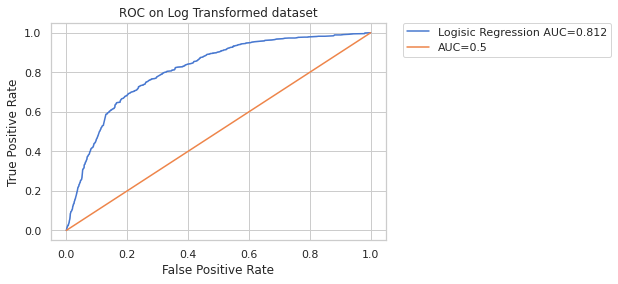

The log loss and auc was found to be 0.542 and 0.812 for Logisic Regression on Log Transformed dataset.


In [9]:
labels=[] #storing all labels
y_preds = [] #storing all y_pred
y_pred = model.predict_proba(X_val)[:,1]
label="Logisic Regression"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result
del result

In [10]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369


# Decision Trees

In [ ]:
model = tree.DecisionTreeClassifier(class_weight='balanced')
params = { 
          'max_depth':[10,100,500,1000,-1], 
         'min_samples_split':[2,5,10,100,500], 
          'min_samples_leaf':[1,3,5,7,10],
          'max_leaf_nodes':[100,500,1000,5000,-1] 
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished


The best auc score was 0.786
The best params were: {'min_samples_split': 500, 'min_samples_leaf': 7, 'max_leaf_nodes': 5000, 'max_depth': 10}
CPU times: user 5.68 s, sys: 266 ms, total: 5.94 s
Wall time: 3min 59s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [11]:
model = tree.DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                        splitter='best')

model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [12]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=10,
                                                             max_features=None,
                                                             max_leaf_nodes=5000,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=7,
                                                             min_samples_split=500,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort='deprecated',
         

		 Decision Tree Classifier on Log Transformed dataset 		 



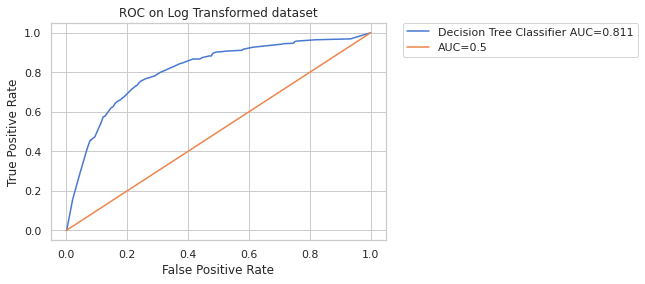

The log loss and auc was found to be 0.141 and 0.811 for Decision Tree Classifier on Log Transformed dataset.


In [13]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Decision Tree Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [14]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504


# Random Forest

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 80.1min finished


The best auc score was 0.817
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 7min 5s, sys: 927 ms, total: 7min 6s
Wall time: 1h 27min 13s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

%time model.fit(X_train,y_train)

CPU times: user 11min 49s, sys: 2.15 s, total: 11min 51s
Wall time: 6min 6s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [16]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier on Log Transformed dataset 		 



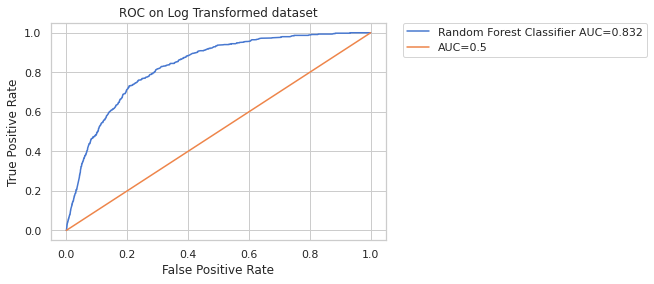

The log loss and auc was found to be 0.138 and 0.832 for Random Forest Classifier on Log Transformed dataset.


In [17]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Random Forest Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [18]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049


# Selecting top features

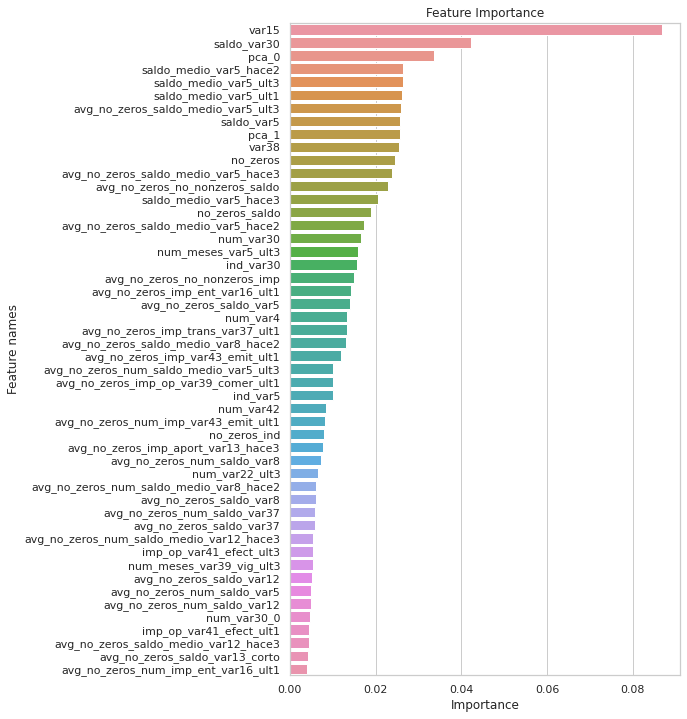

In [19]:
plot_feature_importance(X_train,model.feature_importances_,top=50,size=(7,12))

We will create new datasets with less features.

In [20]:
#getting features that have >=0.01 feature importance value.
top=0.01
features = get_top_features(X_train,model.feature_importances_,top=top)
print("There are %i features that have feature importance value above %.5f"%(len(features),top))
X_train_01 = X_train[features].copy()
X_val_01 = X_val[features].copy()
X_test_01 = X_test[features].copy()

There are 29 features that have feature importance value above 0.01000


In [21]:
#getting top k features
top=100
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_100 = X_train[features].copy()
X_val_100 = X_val[features].copy()
X_test_100 = X_test[features].copy()

Taking top 100 features


In [22]:
#getting top k features
top=250
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_200 = X_train[features].copy()
X_val_200 = X_val[features].copy()
X_test_200 = X_test[features].copy()

Taking top 250 features


# XGB Classifier

In [23]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=750,
                      reg_alpha = 0.2,
                      max_depth=6, 
                      gamma=0, random_state=42
                     )


In [24]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.805145	validation_0-error:0.039726
[1]	validation_0-auc:0.814853	validation_0-error:0.039551
[2]	validation_0-auc:0.824788	validation_0-error:0.039551
[3]	validation_0-auc:0.82374	validation_0-error:0.039551
[4]	validation_0-auc:0.82457	validation_0-error:0.039551
[5]	validation_0-auc:0.825309	validation_0-error:0.039551
[6]	validation_0-auc:0.82671	validation_0-error:0.039551
[7]	validation_0-auc:0.827898	validation_0-error:0.039551
[8]	validation_0-auc:0.827474	validation_0-error:0.039551
[9]	validation_0-auc:0.826936	validation_0-error:0.039551
[10]	validation_0-auc:0.826579	validation_0-error:0.039551
[11]	validation_0-auc:0.828753	validation_0-error:0.039551
[12]	validation_0-auc:0.828517	validation_0-error:0.039551
[13]	validation_0-auc:0.829532	validation_0-error:0.039551
[14]	validation_0-auc:0.82899	validation_0-error:0.039551
[15]	validation_0-auc:0.829413	validation_0-error:0.039551
[16]	validation_0-auc:0.829526	validation_0-error:0.039551
[17]	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=750, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer on Log Transformed dataset 		 



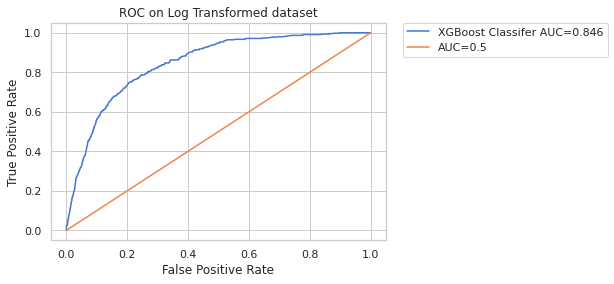

The log loss and auc was found to be 0.133 and 0.846 for XGBoost Classifer on Log Transformed dataset.


In [25]:
y_pred = model.predict_proba(X_val)[:,1]
label="XGBoost Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [26]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133141,0.846035


# LightGBM Classifier

In [27]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = .5,
                      subsample = 0.7,
                      objective='binary', 
                      n_estimators=500,
                      reg_alpha = 0.3,
                      max_depth=8, 
                      gamma=0, random_state=42
                     )


In [28]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165712	valid_0's auc: 0.819959
[2]	valid_0's binary_logloss: 0.164961	valid_0's auc: 0.828604
[3]	valid_0's binary_logloss: 0.164314	valid_0's auc: 0.83104
[4]	valid_0's binary_logloss: 0.163768	valid_0's auc: 0.828448
[5]	valid_0's binary_logloss: 0.163137	valid_0's auc: 0.832022
[6]	valid_0's binary_logloss: 0.162477	valid_0's auc: 0.834172
[7]	valid_0's binary_logloss: 0.16193	valid_0's auc: 0.832036
[8]	valid_0's binary_logloss: 0.161292	valid_0's auc: 0.833988
[9]	valid_0's binary_logloss: 0.160683	valid_0's auc: 0.835053
[10]	valid_0's binary_logloss: 0.160129	valid_0's auc: 0.836393
[11]	valid_0's binary_logloss: 0.159661	valid_0's auc: 0.834638
[12]	valid_0's binary_logloss: 0.159165	valid_0's auc: 0.836207
[13]	valid_0's binary_logloss: 0.158716	valid_0's auc: 0.834935
[14]	valid_0's binary_logloss: 0.158272	valid_0's auc: 0.834205
[15]	valid_0's binary_logloss: 0.157772	valid_0's auc: 0.835857
[16]	valid_0's binary_logloss: 0.157364	valid_0's a

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               gamma=0, importance_type='split', learning_rate=0.01,
               max_depth=8, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=42,
               reg_alpha=0.3, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer on Log Transformed dataset 		 



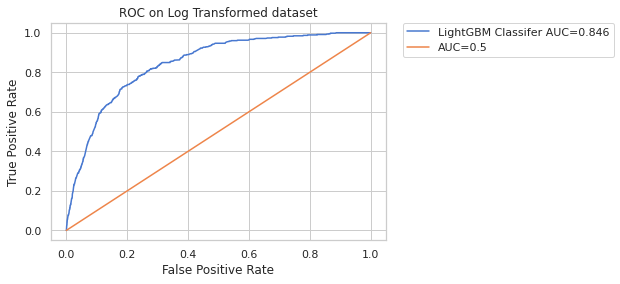

The log loss and auc was found to be 0.133 and 0.846 for LightGBM Classifer on Log Transformed dataset.


In [29]:
y_pred = model.predict_proba(X_val)[:,1]
label="LightGBM Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [30]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133141,0.846035
4,LightGBM Classifer,Log Transformed,0.133203,0.845515


# Random Forest (feature importance>0.01)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_01)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 40.0min finished


The best auc score was 0.821
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 1min 47s, sys: 343 ms, total: 1min 47s
Wall time: 41min 49s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

model.fit(X_train_01,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [32]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_01,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier (feature importance>0.01) on Log Transformed dataset 		 



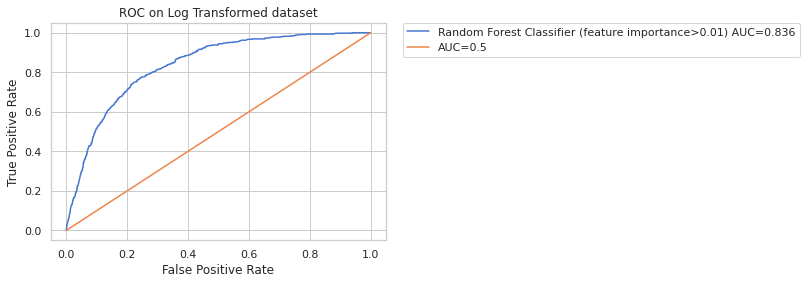

The log loss and auc was found to be 0.137 and 0.836 for Random Forest Classifier (feature importance>0.01) on Log Transformed dataset.


In [33]:
i+=1
y_pred = cc_model.predict_proba(X_val_01)[:,1]
label="Random Forest Classifier (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [34]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133141,0.846035
4,LightGBM Classifer,Log Transformed,0.133203,0.845515
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136757,0.835733


# XGB Classifier (feature importance>0.01)

In [35]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.7,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=1000,
                      reg_alpha = 0.2,
                      max_depth=4, 
                      gamma=0.0, random_state=42
                     )


In [36]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.811612	validation_0-error:0.039551
[1]	validation_0-auc:0.810407	validation_0-error:0.039551
[2]	validation_0-auc:0.81237	validation_0-error:0.039551
[3]	validation_0-auc:0.811942	validation_0-error:0.039551
[4]	validation_0-auc:0.813033	validation_0-error:0.039551
[5]	validation_0-auc:0.812602	validation_0-error:0.039551
[6]	validation_0-auc:0.814767	validation_0-error:0.039551
[7]	validation_0-auc:0.815395	validation_0-error:0.039551
[8]	validation_0-auc:0.817367	validation_0-error:0.039551
[9]	validation_0-auc:0.817284	validation_0-error:0.039551
[10]	validation_0-auc:0.81703	validation_0-error:0.039551
[11]	validation_0-auc:0.817447	validation_0-error:0.039551
[12]	validation_0-auc:0.817579	validation_0-error:0.039551
[13]	validation_0-auc:0.818527	validation_0-error:0.039551
[14]	validation_0-auc:0.817956	validation_0-error:0.039551
[15]	validation_0-auc:0.817213	validation_0-error:0.039551
[16]	validation_0-auc:0.817994	validation_0-error:0.039551
[17]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer(feature importance>0.01) on Log Transformed dataset 		 



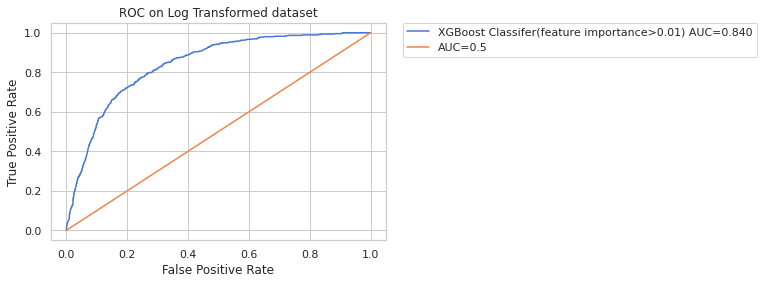

The log loss and auc was found to be 0.135 and 0.840 for XGBoost Classifer(feature importance>0.01) on Log Transformed dataset.


In [37]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="XGBoost Classifer(feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [38]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133141,0.846035
4,LightGBM Classifer,Log Transformed,0.133203,0.845515
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136757,0.835733
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134744,0.840025


# LightGBM Classifier (feature importance>0.01)

In [39]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8,
                      subsample = 0.7,
                      objective='binary', 
                      n_estimators=574,
                      reg_alpha = 0.,
                      max_depth=6, random_state=42
                     )


In [40]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165864	valid_0's auc: 0.788104
[2]	valid_0's binary_logloss: 0.165239	valid_0's auc: 0.795744
[3]	valid_0's binary_logloss: 0.164574	valid_0's auc: 0.811837
[4]	valid_0's binary_logloss: 0.163933	valid_0's auc: 0.814574
[5]	valid_0's binary_logloss: 0.163345	valid_0's auc: 0.817387
[6]	valid_0's binary_logloss: 0.162742	valid_0's auc: 0.822479
[7]	valid_0's binary_logloss: 0.162149	valid_0's auc: 0.824052
[8]	valid_0's binary_logloss: 0.161571	valid_0's auc: 0.824899
[9]	valid_0's binary_logloss: 0.161055	valid_0's auc: 0.825974
[10]	valid_0's binary_logloss: 0.160518	valid_0's auc: 0.826574
[11]	valid_0's binary_logloss: 0.159997	valid_0's auc: 0.827546
[12]	valid_0's binary_logloss: 0.159581	valid_0's auc: 0.826872
[13]	valid_0's binary_logloss: 0.159134	valid_0's auc: 0.827498
[14]	valid_0's binary_logloss: 0.158636	valid_0's auc: 0.828382
[15]	valid_0's binary_logloss: 0.158164	valid_0's auc: 0.82903
[16]	valid_0's binary_logloss: 0.157721	valid_0's 

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.01, max_depth=6,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=574, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=42, reg_alpha=0.0,
               reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=0.7,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer (feature importance>0.01) on Log Transformed dataset 		 



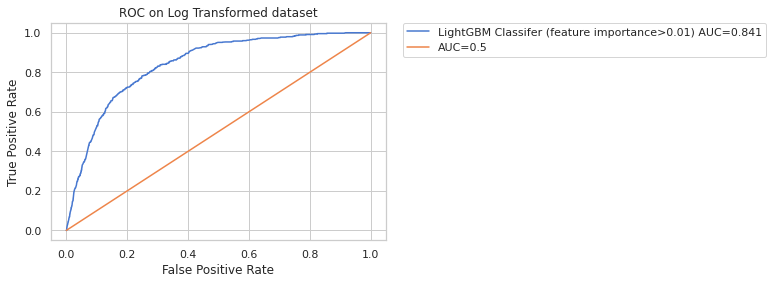

The log loss and auc was found to be 0.135 and 0.841 for LightGBM Classifer (feature importance>0.01) on Log Transformed dataset.


In [41]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="LightGBM Classifer (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [42]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133141,0.846035
4,LightGBM Classifer,Log Transformed,0.133203,0.845515
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136757,0.835733
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134744,0.840025
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134652,0.841347


# Random Forest (top 100)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_100)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 53.1min finished


The best auc score was 0.822
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 5, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 2min 32s, sys: 634 ms, total: 2min 32s
Wall time: 55min 40s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

model.fit(X_train_100,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [44]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_100,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=5,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier (top 100) on Log Transformed dataset 		 



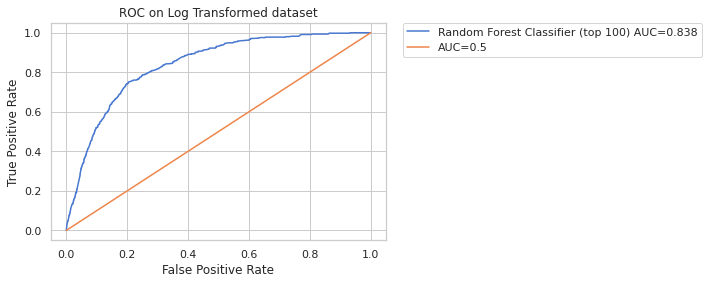

The log loss and auc was found to be 0.136 and 0.838 for Random Forest Classifier (top 100) on Log Transformed dataset.


In [45]:
i+=1
y_pred = cc_model.predict_proba(X_val_100)[:,1]
label="Random Forest Classifier (top 100)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [46]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133141,0.846035
4,LightGBM Classifer,Log Transformed,0.133203,0.845515
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136757,0.835733
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134744,0.840025
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134652,0.841347
8,Random Forest Classifier (top 100),Log Transformed,0.136038,0.837843


# XGB Classifier (top 100)

In [47]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.6,
                      subsample = 1,
                      objective='binary:logistic', 
                      n_estimators=845,
                      reg_alpha = 0.3,
                      max_depth=5, random_state=42
                     )

In [48]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.808532	validation_0-error:0.039639
[1]	validation_0-auc:0.809757	validation_0-error:0.039551
[2]	validation_0-auc:0.812232	validation_0-error:0.039551
[3]	validation_0-auc:0.816003	validation_0-error:0.039551
[4]	validation_0-auc:0.817215	validation_0-error:0.039551
[5]	validation_0-auc:0.819354	validation_0-error:0.039551
[6]	validation_0-auc:0.820278	validation_0-error:0.039551
[7]	validation_0-auc:0.819505	validation_0-error:0.039551
[8]	validation_0-auc:0.819936	validation_0-error:0.039551
[9]	validation_0-auc:0.820103	validation_0-error:0.039551
[10]	validation_0-auc:0.821238	validation_0-error:0.039551
[11]	validation_0-auc:0.821744	validation_0-error:0.039551
[12]	validation_0-auc:0.821954	validation_0-error:0.039551
[13]	validation_0-auc:0.822206	validation_0-error:0.039551
[14]	validation_0-auc:0.823636	validation_0-error:0.039551
[15]	validation_0-auc:0.82385	validation_0-error:0.039551
[16]	validation_0-auc:0.823518	validation_0-error:0.039551
[17]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=845, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

		 XGBoost Classifer(top 100) on Log Transformed dataset 		 



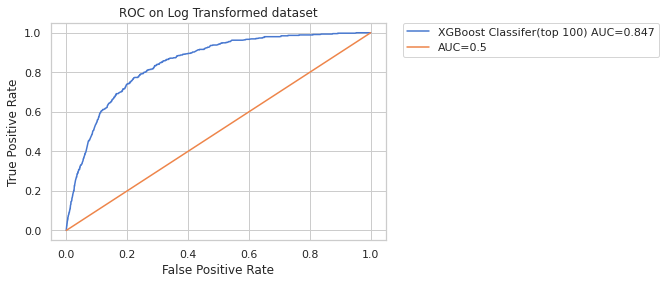

The log loss and auc was found to be 0.133 and 0.847 for XGBoost Classifer(top 100) on Log Transformed dataset.


In [49]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="XGBoost Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [50]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133141,0.846035
4,LightGBM Classifer,Log Transformed,0.133203,0.845515
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136757,0.835733
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134744,0.840025
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134652,0.841347
8,Random Forest Classifier (top 100),Log Transformed,0.136038,0.837843
9,XGBoost Classifer(top 100),Log Transformed,0.132819,0.847317


# LightGBM Classifier (top 100)

In [51]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 1,
                      objective='binary', 
                      n_estimators=947,
                      reg_alpha = 0.4,
                      max_depth=5, random_state=42)


In [52]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165888	valid_0's auc: 0.792505
[2]	valid_0's binary_logloss: 0.16526	valid_0's auc: 0.798136
[3]	valid_0's binary_logloss: 0.164659	valid_0's auc: 0.800474
[4]	valid_0's binary_logloss: 0.164026	valid_0's auc: 0.8192
[5]	valid_0's binary_logloss: 0.163421	valid_0's auc: 0.822416
[6]	valid_0's binary_logloss: 0.162896	valid_0's auc: 0.820874
[7]	valid_0's binary_logloss: 0.162375	valid_0's auc: 0.819567
[8]	valid_0's binary_logloss: 0.161797	valid_0's auc: 0.820309
[9]	valid_0's binary_logloss: 0.161309	valid_0's auc: 0.819754
[10]	valid_0's binary_logloss: 0.160894	valid_0's auc: 0.819236
[11]	valid_0's binary_logloss: 0.160455	valid_0's auc: 0.819379
[12]	valid_0's binary_logloss: 0.160039	valid_0's auc: 0.818256
[13]	valid_0's binary_logloss: 0.159643	valid_0's auc: 0.817997
[14]	valid_0's binary_logloss: 0.159185	valid_0's auc: 0.819798
[15]	valid_0's binary_logloss: 0.158722	valid_0's auc: 0.822602
[16]	valid_0's binary_logloss: 0.1583	valid_0's auc:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.01, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=947, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=42, reg_alpha=0.4,
               reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=1,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 100) on Log Transformed dataset 		 



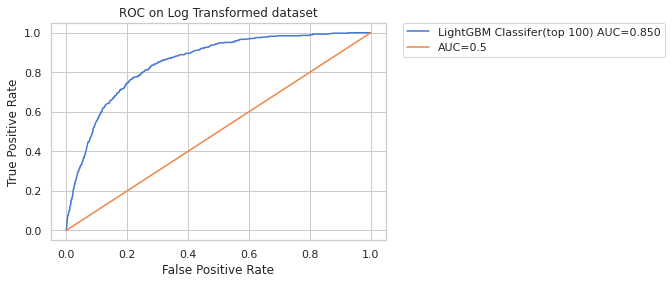

The log loss and auc was found to be 0.132 and 0.850 for LightGBM Classifer(top 100) on Log Transformed dataset.


In [53]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="LightGBM Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [54]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133141,0.846035
4,LightGBM Classifer,Log Transformed,0.133203,0.845515
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136757,0.835733
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134744,0.840025
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134652,0.841347
8,Random Forest Classifier (top 100),Log Transformed,0.136038,0.837843
9,XGBoost Classifer(top 100),Log Transformed,0.132819,0.847317


# Random Forest (top 250)

In [55]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_200)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 70.1min finished


The best auc score was 0.818
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 6min 5s, sys: 2.21 s, total: 6min 7s
Wall time: 1h 16min 10s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [56]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)
model.fit(X_train_200,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [57]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_200,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier (top 250) on Log Transformed dataset 		 



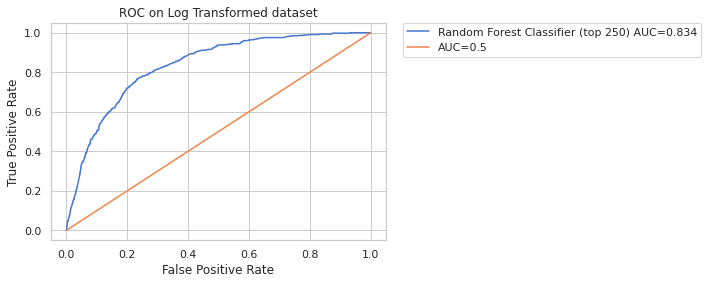

The log loss and auc was found to be 0.137 and 0.834 for Random Forest Classifier (top 250) on Log Transformed dataset.


In [58]:
i+=1
y_pred = cc_model.predict_proba(X_val_200)[:,1]
label="Random Forest Classifier (top 250)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [59]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133141,0.846035
4,LightGBM Classifer,Log Transformed,0.133203,0.845515
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136757,0.835733
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134744,0.840025
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134652,0.841347
8,Random Forest Classifier (top 100),Log Transformed,0.136038,0.837843
9,XGBoost Classifer(top 100),Log Transformed,0.132819,0.847317


# XGB Classifier (top 250)

In [60]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8, 
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=845,
                      reg_alpha = 0.3,
                      max_depth=7,
                      gamma=0, random_state=42
                     )

In [61]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.785132	validation_0-error:0.041217
[1]	validation_0-auc:0.789707	validation_0-error:0.039989
[2]	validation_0-auc:0.795043	validation_0-error:0.039902
[3]	validation_0-auc:0.810454	validation_0-error:0.039639
[4]	validation_0-auc:0.816158	validation_0-error:0.039639
[5]	validation_0-auc:0.820586	validation_0-error:0.039639
[6]	validation_0-auc:0.822935	validation_0-error:0.039551
[7]	validation_0-auc:0.825132	validation_0-error:0.039551
[8]	validation_0-auc:0.825288	validation_0-error:0.039551
[9]	validation_0-auc:0.825942	validation_0-error:0.039551
[10]	validation_0-auc:0.825801	validation_0-error:0.039551
[11]	validation_0-auc:0.82276	validation_0-error:0.039551
[12]	validation_0-auc:0.824231	validation_0-error:0.039551
[13]	validation_0-auc:0.823506	validation_0-error:0.039551
[14]	validation_0-auc:0.82415	validation_0-error:0.039551
[15]	validation_0-auc:0.825524	validation_0-error:0.039551
[16]	validation_0-auc:0.825356	validation_0-error:0.039551
[17]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=845, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

		 XGBoost Classifer(top 250) on Log Transformed dataset 		 



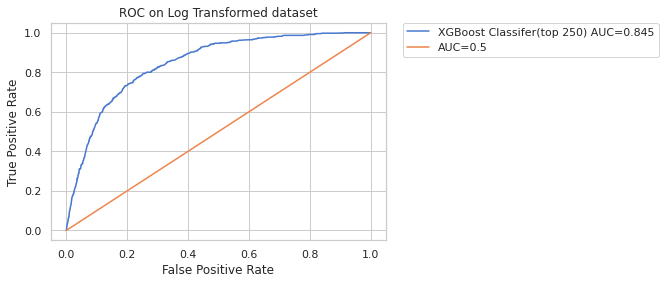

The log loss and auc was found to be 0.133 and 0.845 for XGBoost Classifer(top 250) on Log Transformed dataset.


In [62]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="XGBoost Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [63]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed,0.541988,0.812369
1,Decision Tree Classifier,Log Transformed,0.140748,0.810504
2,Random Forest Classifier,Log Transformed,0.137583,0.832049
3,XGBoost Classifer,Log Transformed,0.133141,0.846035
4,LightGBM Classifer,Log Transformed,0.133203,0.845515
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136757,0.835733
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134744,0.840025
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134652,0.841347
8,Random Forest Classifier (top 100),Log Transformed,0.136038,0.837843
9,XGBoost Classifer(top 100),Log Transformed,0.132819,0.847317


# LightGBM Classifier (top 250)

In [64]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary', 
                      n_estimators=447,
                      reg_alpha = 0,
                      max_depth=6, random_state=42
                     )

In [65]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165849	valid_0's auc: 0.789789
[2]	valid_0's binary_logloss: 0.165231	valid_0's auc: 0.807777
[3]	valid_0's binary_logloss: 0.16461	valid_0's auc: 0.811263
[4]	valid_0's binary_logloss: 0.164039	valid_0's auc: 0.815292
[5]	valid_0's binary_logloss: 0.163488	valid_0's auc: 0.815698
[6]	valid_0's binary_logloss: 0.162843	valid_0's auc: 0.82064
[7]	valid_0's binary_logloss: 0.16227	valid_0's auc: 0.823982
[8]	valid_0's binary_logloss: 0.16173	valid_0's auc: 0.822848
[9]	valid_0's binary_logloss: 0.161236	valid_0's auc: 0.821481
[10]	valid_0's binary_logloss: 0.160722	valid_0's auc: 0.82434
[11]	valid_0's binary_logloss: 0.160196	valid_0's auc: 0.825397
[12]	valid_0's binary_logloss: 0.159685	valid_0's auc: 0.828144
[13]	valid_0's binary_logloss: 0.159264	valid_0's auc: 0.827227
[14]	valid_0's binary_logloss: 0.15882	valid_0's auc: 0.826351
[15]	valid_0's binary_logloss: 0.158391	valid_0's auc: 0.826528
[16]	valid_0's binary_logloss: 0.157958	valid_0's auc: 

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.01, max_depth=6,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=447, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=42, reg_alpha=0, reg_lambda=0.0,
               scale_pos_weight=1, silent=True, subsample=0.9,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 250) on Log Transformed dataset 		 



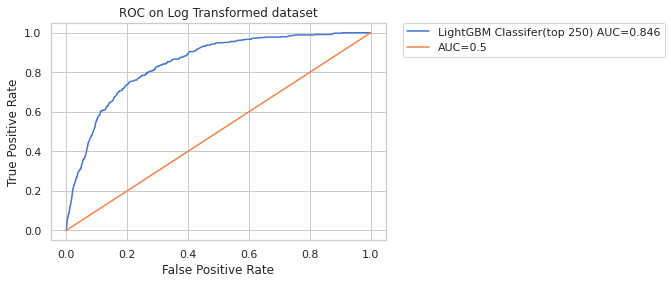

The log loss and auc was found to be 0.133 and 0.846 for LightGBM Classifer(top 250) on Log Transformed dataset.


In [66]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="LightGBM Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

# Combined

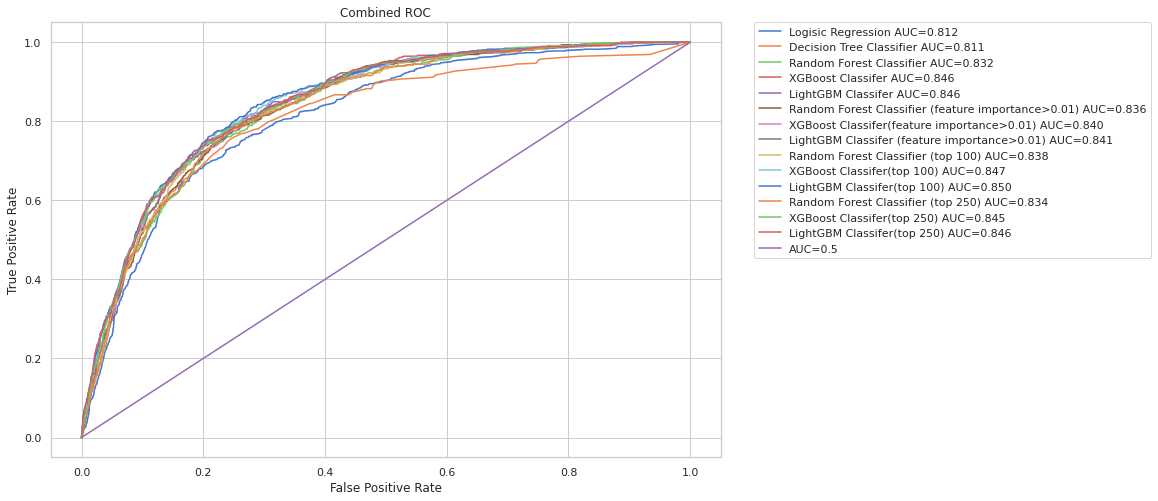

In [67]:
plot_auc(y_val,y_preds,labels)

In [68]:
result_df.sort_values(by='auc',ascending=False)

,Model,Dataset,log_loss,auc
10,LightGBM Classifer(top 100),Log Transformed,0.132075,0.849663
9,XGBoost Classifer(top 100),Log Transformed,0.132819,0.847317
3,XGBoost Classifer,Log Transformed,0.133141,0.846035
13,LightGBM Classifer(top 250),Log Transformed,0.133233,0.845900
4,LightGBM Classifer,Log Transformed,0.133203,0.845515
12,XGBoost Classifer(top 250),Log Transformed,0.133320,0.845188
7,LightGBM Classifer (feature importance>0.01),Log Transformed,0.134652,0.841347
6,XGBoost Classifer(feature importance>0.01),Log Transformed,0.134744,0.840025
8,Random Forest Classifier (top 100),Log Transformed,0.136038,0.837843
5,Random Forest Classifier (feature importance>0...,Log Transformed,0.136757,0.835733


# Saving all the datasets created

In [69]:
import joblib
filename = 'log_train_100.pkl'
X_train_100.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_val_100.pkl'
X_val_100.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_test_100.pkl'
X_test_100.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_train_250.pkl'
X_train_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_val_250.pkl'
X_val_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_test_250.pkl'
X_test_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_train_01.pkl'
X_train_01.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_val_01.pkl'
X_val_01.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_test_01.pkl'
X_test_01.to_pickle(os.path.join(file_path,'best_models',filename))